# Lucas Tree

## Question 1

In [296]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as opt
import pandas_datareader.data as web

In [297]:
start = datetime.datetime(1972, 1, 1)
end = datetime.datetime(2010, 12, 31)

consumption = web.DataReader('PCECC96', 'fred', start, end) 
market = web.DataReader('WILL5000INDFC', 'fred', start, end) 
t_bill = web.DataReader('TB3MS', 'fred', start, end)         
deflator = web.DataReader('GDPDEF', 'fred', start, end)      


df = pd.concat([consumption, market, deflator, t_bill], sort=True)
df = df.groupby(pd.PeriodIndex(df.index, freq='Q'), axis=0).mean() # convert to quarterly

df.columns = ['consumption', 'market', 'deflator', 't_bill']
df['rMarket'] = df.market / (df.deflator*100)
df['rTbill'] = df.t_bill / (df.deflator*100)


### not sure how to deflate tbill
df.head()

,consumption,market,deflator,t_bill,rMarket,rTbill
DATE,,,,,,
1972Q1,24.664,3110.801,3.436667,1.240000,9.051797,0.003608
1972Q2,24.815,3170.159,3.770000,1.280000,8.408910,0.003395
1972Q3,25.048,3219.095,4.220000,1.293333,7.628187,0.003065
1972Q4,25.366,3294.606,4.863333,1.356667,6.774378,0.002790
1973Q1,25.661,3354.764,5.700000,1.306667,5.885551,0.002292


Assume that 𝛽 = 0.99 (since this is quarterly data, this implies an annual risk- free rate of about 4%). Calculate empirical analogs of the expected values and covariance in (5). Using scipy.optimize.broyden1, solve for the value of 𝛾 that leads to equation (5) holding.


In [311]:
class GMM_Lucas( object ):   
    def __init__(self, data=df, options='q3'):
        
        self.data = data
        self.options = options
                
        R = self.data.rMarket / self.data.rMarket.shift(1)
        self.R = R.dropna()
        
    def estimate_m(self, gamma, beta):
        ratio = self.data.consumption / self.data.consumption.shift(1)
        
        MUC = ratio ** -gamma     
        m = beta * MUC
        return m[1:]
 
    def objective(self, params):
        if params.size == 1:
            gamma = params
            beta = 0.99
            
        if self.options == 'q1':
            m = self.estimate_m(gamma, beta)
            cov = np.cov(m, self.R)[0,1]              # var/cov matrix, take COV
            error = cov + m.mean() * self.R.mean() - 1
            return error
        
        elif self.options == 'q3':        
            m = self.estimate_m(gamma, beta)
            exp = self.R * m
            error = exp.mean() - 1
            return error
        
        elif self.options == 'q4':
            beta, gamma = params
            m = self.estimate_m(gamma, beta)
            cov = np.cov(m, self.R)[0,1]
            err1 = cov + m.mean() * self.R.mean() - 1

            exp = self.R * m
            err2 = exp.mean() - 1
            
            e = np.array([err1, err2])
            return e.T @ np.eye(2) @ e

                   
    def estimate_gamma(self):
        if self.options == 'q4':
            xguess = np.ones(2)
            result = opt.minimize(self.objective, xguess)
        else:
            xguess = np.ones(1)
            ### Non=linear solver gets very different answer to Natasha, come back
            result = opt.broyden1(self.objective, xguess)
        return result
    
    def plot(self):
        n = 60
        N = 5
        γ_grid = np.linspace(0, 5, n)
        β_grid = np.linspace(0.95, 0.99, N)

        cons = self.data.rMarket
        tbill = self.data.rTbill

        gmm_values = np.empty((n, N))
        for i in range(n):
            for j in range(N):
                param = np.array( [ γ_grid[i], β_grid[j] ])
                gmm_values[i, j] = self.objective(param)
                
        plt.figure(figsize=(10, 8))
        for j in range(N):
            plt.plot(γ_grid, gmm_values[:, j], label=f'{β_grid[j]:.2f}')
        plt.title('Value of GMM objective function')
        plt.xlabel('$\gamma$')
        plt.legend()
        plt.show()

In [312]:
Question1 = GMM_Lucas(data=df, options='q1')
print("Gamma = ",Question1.estimate_gamma())

Gamma =  [5.46884087]


## Question 2

I would want to try this on a different data set or a different subset of our data to see if gamma is robust to different specifications. I would also check to see whether or not using a different equation to estimate yields the same results. 

## Question 3

In [313]:
Question3 = GMM_Lucas(data=df, options='q3')
print("Gamma = ",Question3.estimate_gamma())

Gamma =  [5.46718973]


## Question 4

Beta  =  0.9525479906503267 
Gamma =  1.0004136745416046

This is super interesting. When I allow beta to fluctuate, this provides a much lower value gamma because beta can explain some of the savings. 


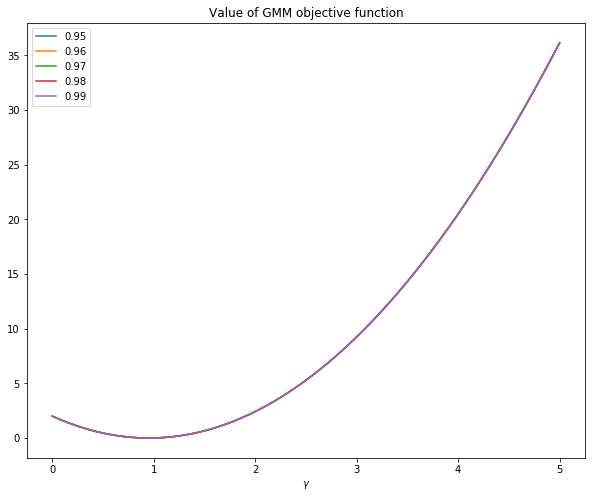

In [314]:
Question4 = GMM_Lucas(data=df, options='q4')
ans = Question4.estimate_gamma().x
print("Beta  = ", ans[0], "\nGamma = ", ans[1])

print("\nThis is super interesting. When I allow beta to fluctuate, this provides a much lower value gamma because"
     + " beta can explain some of the savings. ")

Question4.plot()

# Kyle Model

## Question 1

In [315]:
class OrderBook(object):
    def __init__(self, data):
        self.data = data
        

In [291]:
a = OrderBook(df)
a.data

,consumption,market,deflator,t_bill,rMarket,rTbill
DATE,,,,,,
1972Q1,24.664,3110.801,3.436667,1.240000,9.051797,0.003608
1972Q2,24.815,3170.159,3.770000,1.280000,8.408910,0.003395
1972Q3,25.048,3219.095,4.220000,1.293333,7.628187,0.003065
1972Q4,25.366,3294.606,4.863333,1.356667,6.774378,0.002790
1973Q1,25.661,3354.764,5.700000,1.306667,5.885551,0.002292
1973Q2,26.052,3353.357,6.603333,1.196667,5.078279,0.001812
1973Q3,26.549,3365.331,8.323333,1.243333,4.043249,0.001494
1973Q4,27.077,3355.493,7.500000,1.176667,4.473991,0.001569
1974Q1,27.592,3326.205,7.616667,1.130000,4.367009,0.001484
